In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.cluster.hierarchy import linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score
import umap
from scipy.cluster.hierarchy import dendrogram

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_shape_z = pd.read_csv(os.path.join(folder_path, "features_shape_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_shape_mm = pd.read_csv(os.path.join(folder_path, "features_shape_minmax.csv"))

In [3]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_shape_z_cl= df_shape_z.drop(columns=['filename', 'label'])

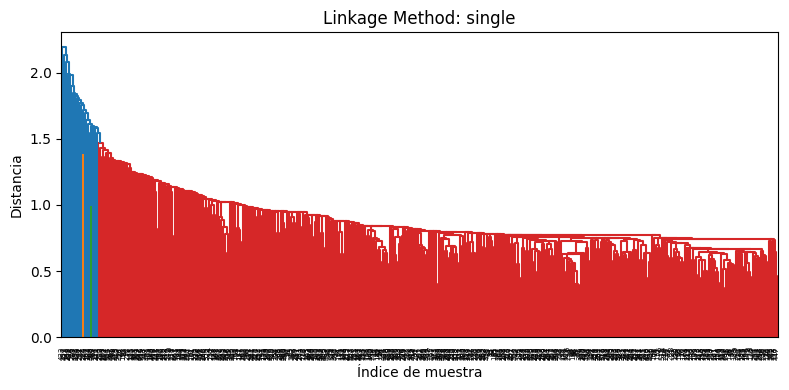

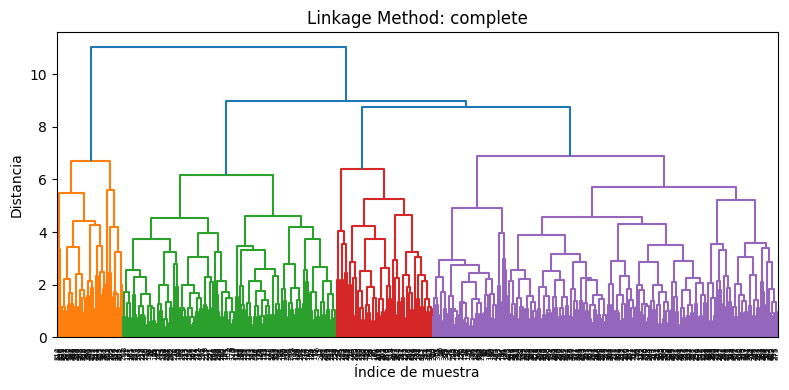

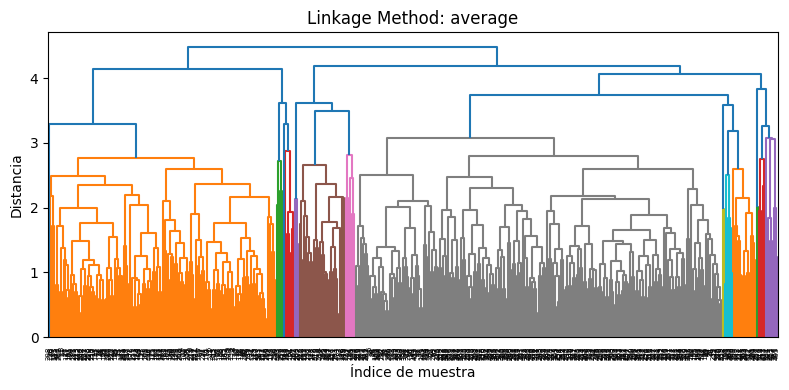

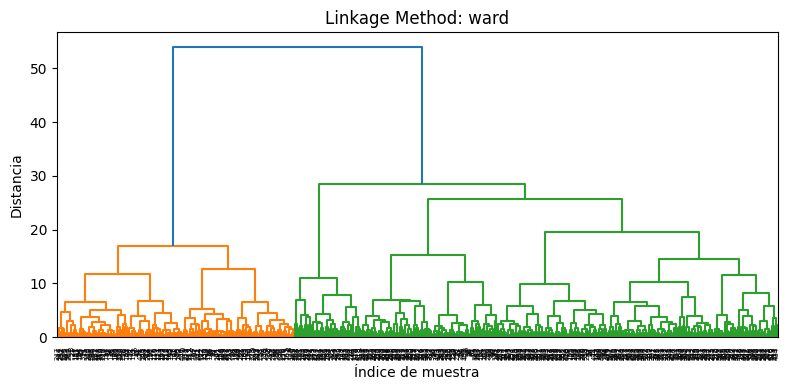

In [4]:
# Comparar diferentes métodos de linkage
methods = ['single', 'complete', 'average', 'ward']

for method in methods:
    clusters = linkage(df_shape_z_cl, method=method)
    plt.figure(figsize=(8, 4))
    dendrogram(clusters)
    plt.title(f'Linkage Method: {method}')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()

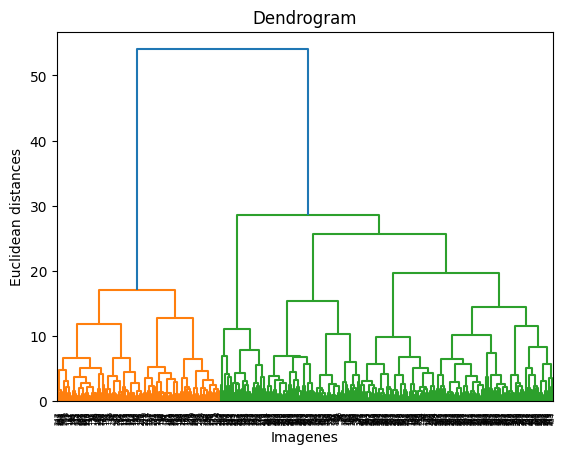

In [5]:
# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(df_shape_z_cl, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

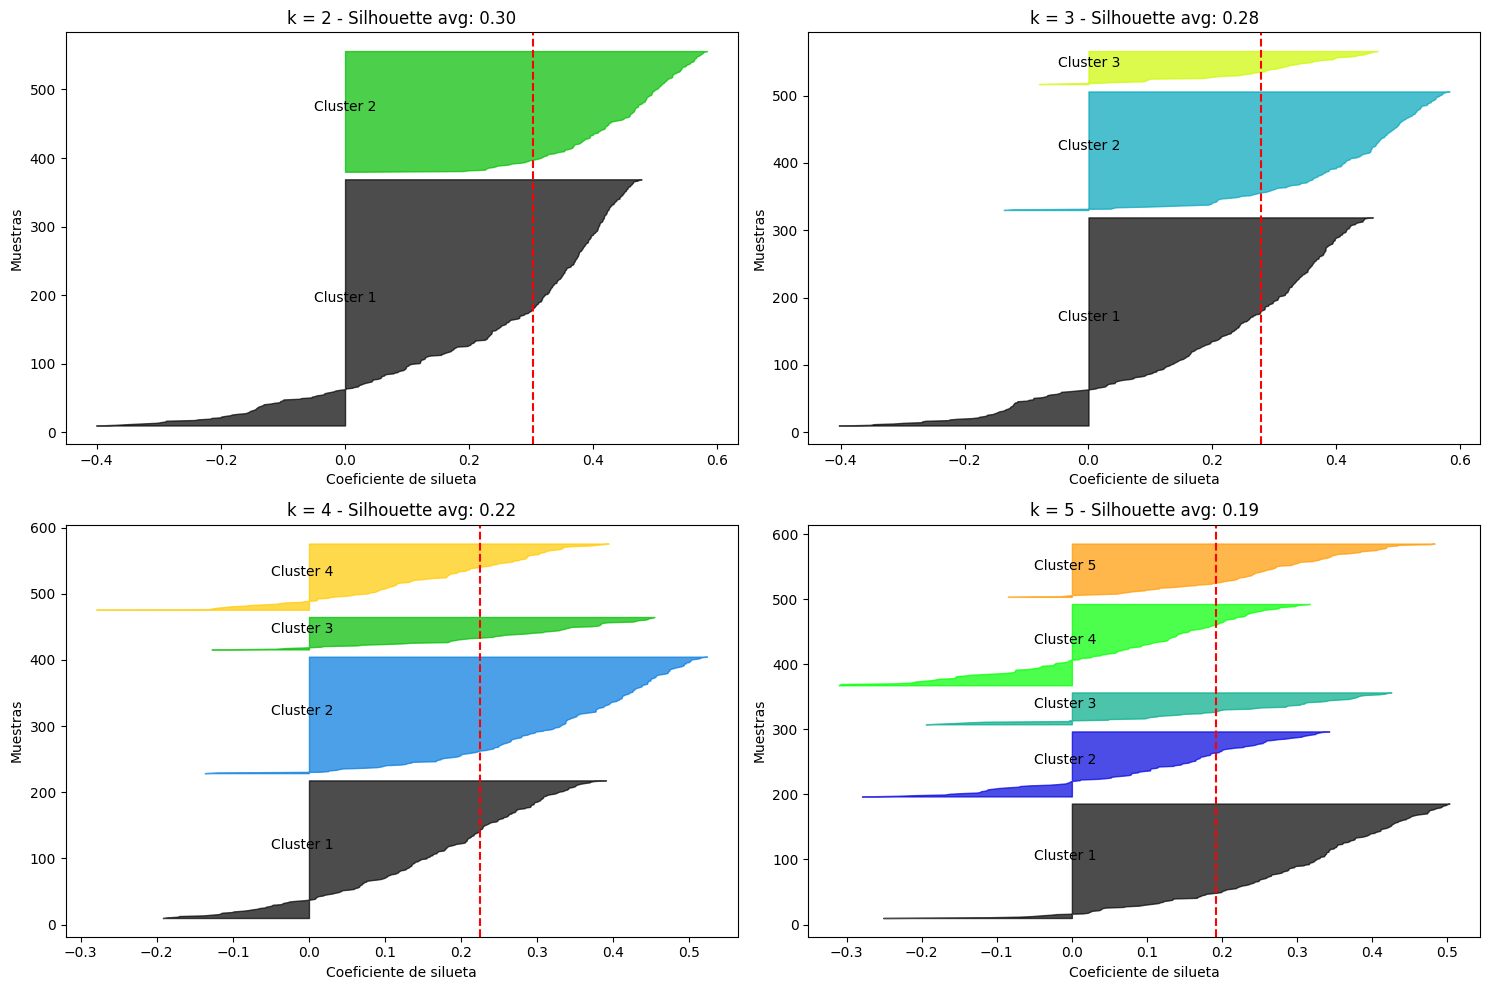

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con 2, 3, 4 y 5 clusters
for i, k in enumerate([2, 3, 4, 5]):
    clusterer = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = clusterer.fit_predict(df_shape_z_cl)
    silhouette_vals = silhouette_samples(df_shape_z_cl, labels)
    silhouette_avg = silhouette_score(df_shape_z_cl, labels)

    # Subplot row/col
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]
    y_lower = 10

    for j in range(k):
        j_silhouette_vals = silhouette_vals[labels == j]
        j_silhouette_vals.sort()
        size = len(j_silhouette_vals)
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(j) / k)
        ax_i.fill_betweenx(np.arange(y_lower, y_upper), 0, j_silhouette_vals,
                           facecolor=color, edgecolor=color, alpha=0.7)
        ax_i.text(-0.05, y_lower + size / 2, f'Cluster {j+1}')
        y_lower = y_upper + 10

    ax_i.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg:.2f}')
    ax_i.set_xlabel("Coeficiente de silueta")
    ax_i.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

Se podría "cortar" entre 20-30, por tanto, 2 clusteres-

In [7]:
hc_z = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_z = hc_z.fit_predict(df_shape_z_cl)


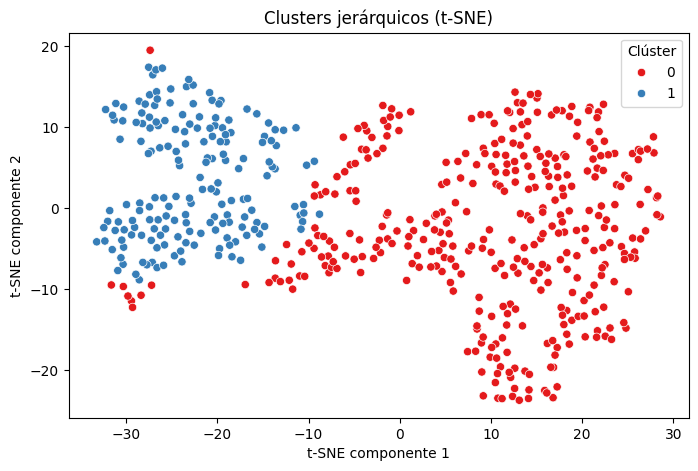

          filename         label  cluster
0      callo_1.png  smaller_than        1
1     callo_10.png  smaller_than        0
2    callo_100.png  smaller_than        1
3    callo_101.png  smaller_than        1
4    callo_102.png  smaller_than        1
..             ...           ...      ...
532   callo_95.png   higher_than        0
533   callo_96.png   higher_than        0
534   callo_97.png   higher_than        0
535   callo_98.png   higher_than        0
536   callo_99.png   higher_than        0

[537 rows x 3 columns]


In [8]:
#Visualización alternativa con t-SNE (
tsne_z = TSNE(n_components=2, random_state=42)
X_tsne_z = tsne_z.fit_transform(df_shape_z_cl)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_z[:, 0], y=X_tsne_z[:, 1], hue=y_hc_z, palette='Set1')
plt.title('Clusters jerárquicos (t-SNE)')
plt.xlabel('t-SNE componente 1')
plt.ylabel('t-SNE componente 2')
plt.legend(title='Clúster')
plt.show()

df_resultado_z = pd.DataFrame({
    'filename': df_shape_z['filename'], 
    'label': df_shape_z['label'],
    'cluster': y_hc_z
})

print(df_resultado_z)

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


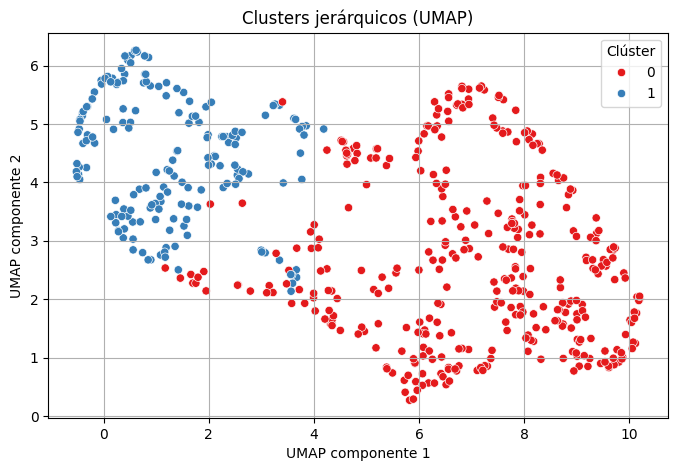

In [9]:
umap_z = umap.UMAP(n_components=2, random_state=42)
X_umap_z = umap_z.fit_transform(df_shape_z_cl)


plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_z[:, 0], y=X_umap_z[:, 1], hue=y_hc_z, palette='Set1')
plt.title('Clusters jerárquicos (UMAP)')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()


In [10]:
# Crear la tabla de contingencia entre 'label' y 'cluster'
contingency_table = pd.crosstab(df_resultado_z['label'], df_resultado_z['cluster'])

# Mostrar la tabla de contingencia
print(contingency_table)


cluster         0    1
label                 
higher_than   260    8
smaller_than  100  169


el cluster 0 está bastante mezclado de smaller y higher, pro es que en smaller hay callos que son del color de los oscuros, o incluso había callos higher en la celda pero como los calllos pequeños eran muy pequeños bajaban la media de la celda, pude que sea ese el problema.

In [11]:
# y_hc_z son las etiquetas del clustering, df_fourier_z_cl los datos
score = silhouette_score(df_shape_z_cl, y_hc_z)
print(f'Silhouette Score: {score:.3f}')


Silhouette Score: 0.303


Se hace lo mismo pero con la normalización min-max

In [12]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_shape_mm_cl= df_shape_mm.drop(columns=['filename', 'label'])

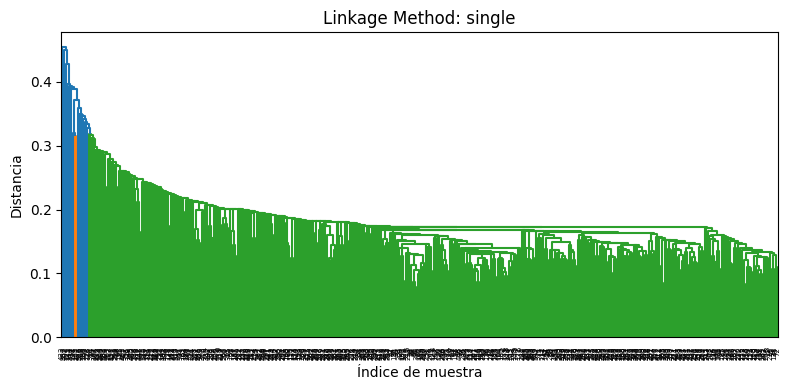

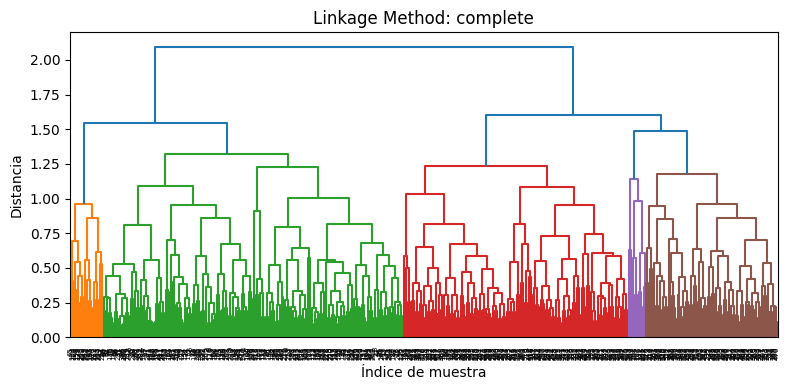

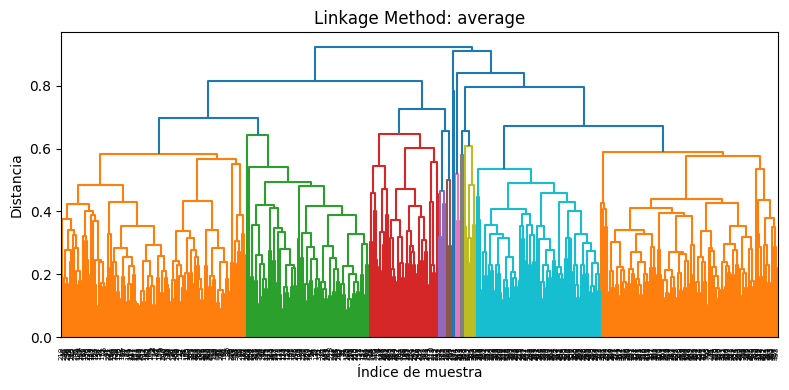

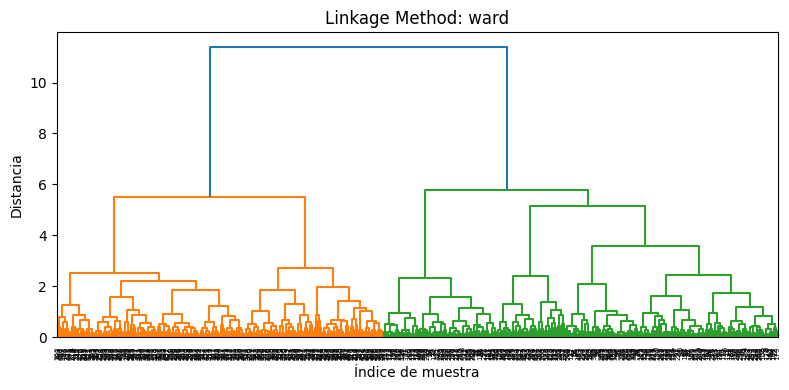

In [14]:
from scipy.cluster.hierarchy import dendrogram
# Comparar diferentes métodos de linkage
methods = ['single', 'complete', 'average', 'ward']

for method in methods:
    clusters = linkage(df_shape_mm_cl, method=method)
    plt.figure(figsize=(8, 4))
    dendrogram(clusters)
    plt.title(f'Linkage Method: {method}')
    plt.xlabel('Índice de muestra')
    plt.ylabel('Distancia')
    plt.tight_layout()
    plt.show()

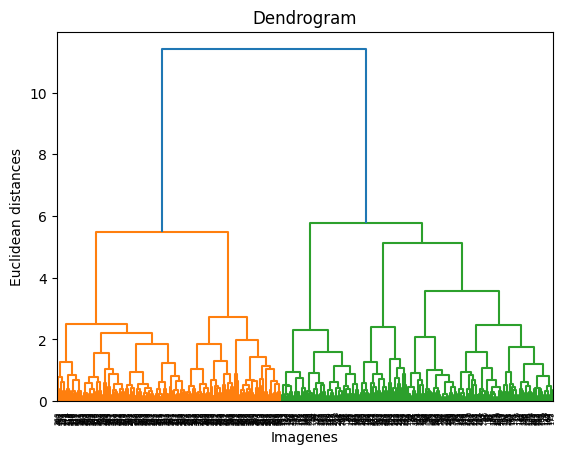

In [15]:
# Using the dendrogram to find the optimal number of clusters
dendrogram_mm = sch.dendrogram(sch.linkage(df_shape_mm_cl, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

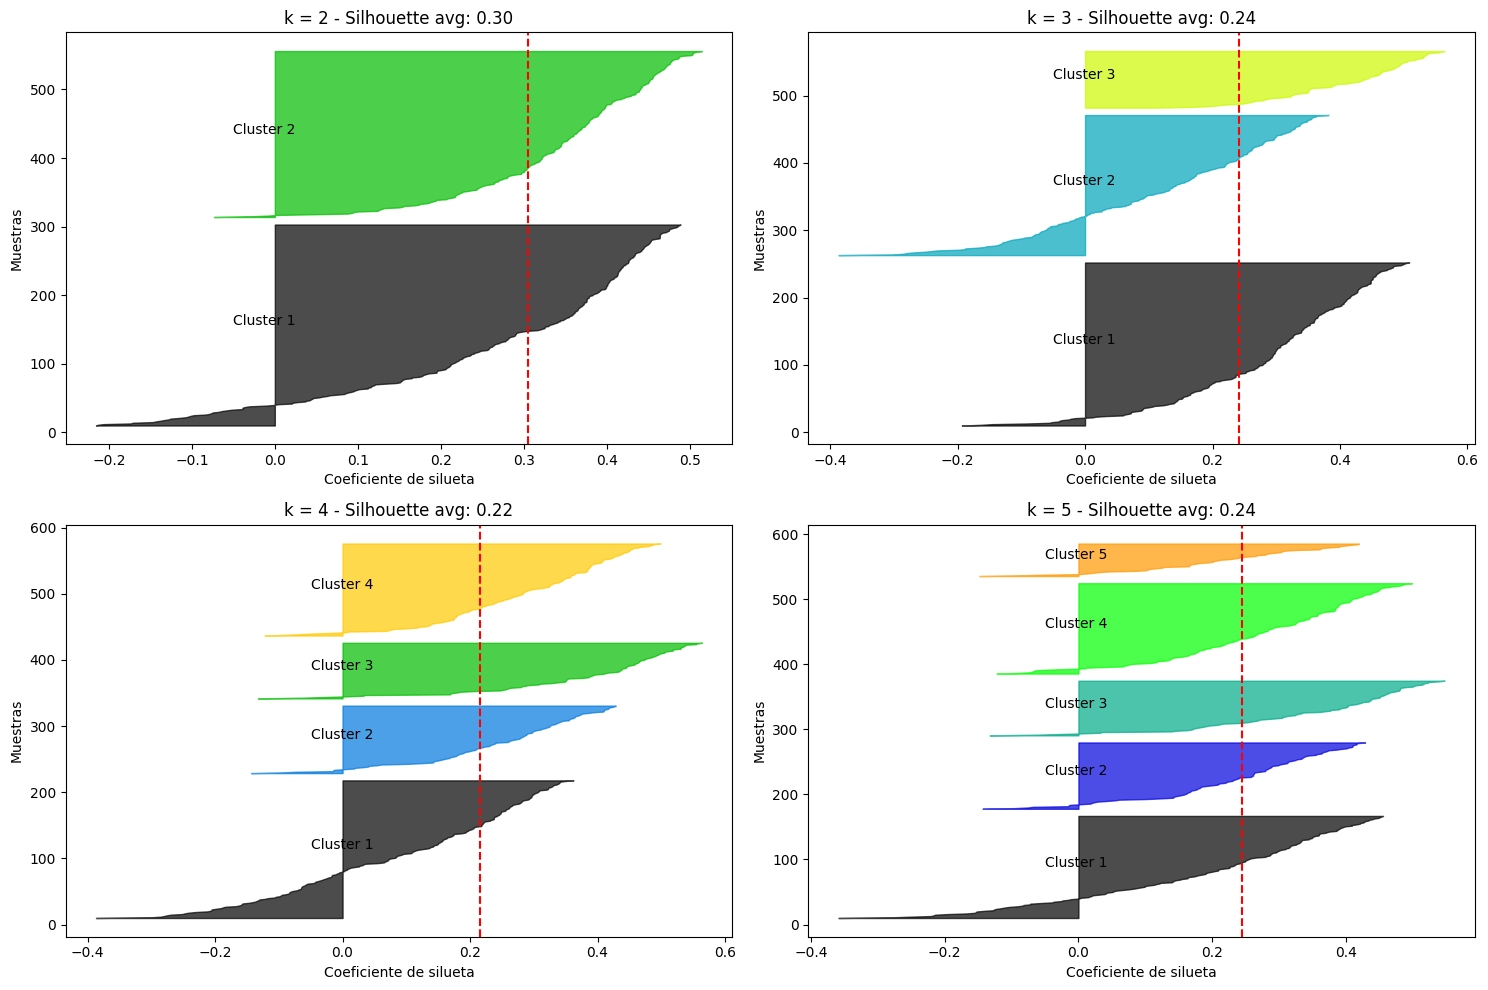

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con 2, 3, 4 y 5 clusters
for i, k in enumerate([2, 3, 4, 5]):
    clusterer_mm = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = clusterer_mm.fit_predict(df_shape_mm_cl)  
    silhouette_vals_mm = silhouette_samples(df_shape_mm_cl, labels)
    silhouette_avg_mm = silhouette_score(df_shape_mm_cl, labels)

    # Subplot row/col
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]
    y_lower = 10

    for j in range(k):
        j_silhouette_vals_mm = silhouette_vals_mm[labels == j]
        j_silhouette_vals_mm.sort()
        size = len(j_silhouette_vals_mm)
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(j) / k)
        ax_i.fill_betweenx(np.arange(y_lower, y_upper), 0, j_silhouette_vals_mm,
                           facecolor=color, edgecolor=color, alpha=0.7)
        ax_i.text(-0.05, y_lower + size / 2, f'Cluster {j+1}')
        y_lower = y_upper + 10

    ax_i.axvline(x=silhouette_avg_mm, color="red", linestyle="--")
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg_mm:.2f}')
    ax_i.set_xlabel("Coeficiente de silueta")
    ax_i.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

In [17]:
hc_mm = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_mm = hc_z.fit_predict(df_shape_mm_cl)

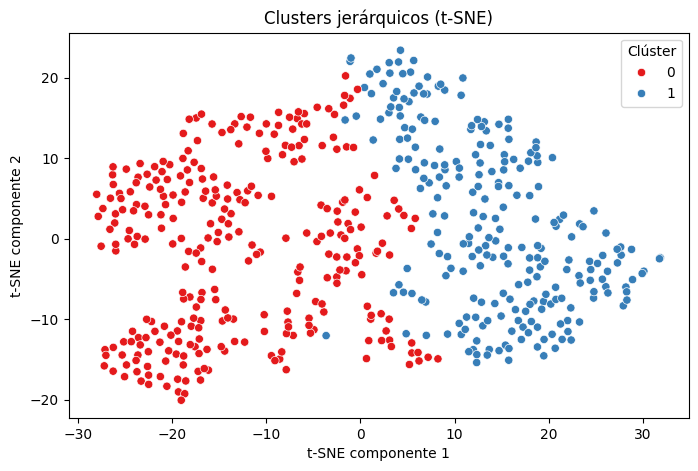

        filename         label  cluster
0    callo_1.png  smaller_than        0
1   callo_10.png  smaller_than        1
2  callo_100.png  smaller_than        0
3  callo_101.png  smaller_than        0
4  callo_102.png  smaller_than        0


In [18]:
#Visualización alternativa con t-SNE 
tsne_mm = TSNE(n_components=2, random_state=42)
X_tsne_mm = tsne_mm.fit_transform(df_shape_mm_cl)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_mm[:, 0], y=X_tsne_mm[:, 1], hue=y_hc_mm, palette='Set1')
plt.title('Clusters jerárquicos (t-SNE)')
plt.xlabel('t-SNE componente 1')
plt.ylabel('t-SNE componente 2')
plt.legend(title='Clúster')
plt.show()

df_resultado_mm = pd.DataFrame({
    'filename': df_shape_mm['filename'], 
    'label': df_shape_mm['label'],
    'cluster': y_hc_mm
})

print(df_resultado_mm.head())

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


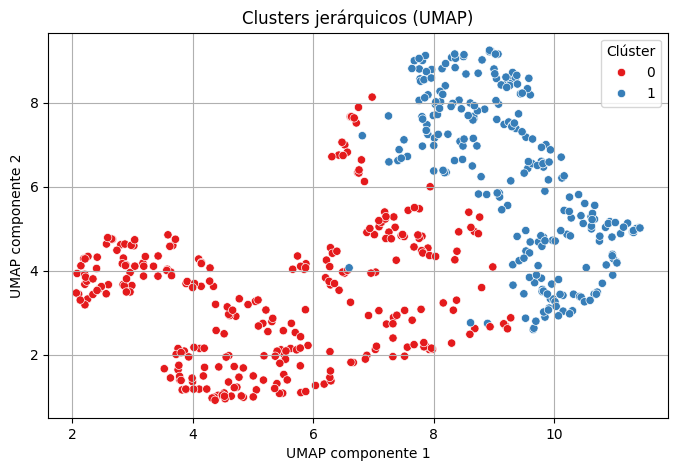

In [19]:
umap_mm = umap.UMAP(n_components=2, random_state=42)
X_umap_mm = umap_mm.fit_transform(df_shape_mm_cl)


plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_mm[:, 0], y=X_umap_mm[:, 1], hue=y_hc_mm, palette='Set1')
plt.title('Clusters jerárquicos (UMAP)')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

In [20]:
# Crear la tabla de contingencia entre 'label' y 'cluster'
contingency_table_mm = pd.crosstab(df_resultado_mm['label'], df_resultado_mm['cluster'])

# Mostrar la tabla de contingencia
print(contingency_table_mm)


cluster         0    1
label                 
higher_than    42  226
smaller_than  252   17


In [21]:
# y_hc_z son las etiquetas del clustering, df_fourier_z_cl los datos
score_mm = silhouette_score(df_shape_mm_cl, y_hc_mm)
print(f'Silhouette Score: {score_mm:.3f}')

Silhouette Score: 0.305


no salen mallos clusteres pero tienen mala silueta pq estan muy juntos